# data preprocessing

In [4]:
import re
import pickle
from collections import Counter

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from soynlp.normalizer import repeat_normalize
from PIL import Image
from tqdm.notebook import tqdm

from utils import load_json, save_pickle
from tokenizer import Tokenizer


cfg = load_json("config.json")

In [34]:
get_khaiii_api, , pos_text, stemming_text
api = get_khaiii_api('/mnt/subdisk/workspace/khaiii/build/share/khaiii')

In [35]:
df = pd.read_excel("resource/ine_coment.xlsx")
df.head()

,title,desc,name,time,comment
0,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,ᄋᄋ,2021-11-12 03:04:35,아이네님 먹는 경양식 돈까스 브랜드가 뭔지 알 수 있을까요?
1,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,Gsg Shim,2021-11-12 02:32:24,아웃트로 음악 뭔지 아시는분 ㅜㅠ
2,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,루미더스,2021-11-12 02:12:40,최애 버거에 대한 진심이 느겨지는 영상 입니닼ㅋㅋㅋ
3,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,쵸핑,2021-11-12 00:08:23,"색깔 취향 확고, 음식 취향 확고 등... 종합해보면 아이네님의 덕력은 역시 이세돌..."
4,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,짬통,2021-11-11 23:49:58,"""복에 겨워서 감흥이 없어요"" ""냔냔냐! 냔냔냐냐!!"""


In [36]:
def normalize(text):
    text = text.replace("_x000D_", " ")
    text = text.replace("\n", " ")
    text = text.replace("넴", "님")
    text = text.replace("는데", "다")
    text = text.replace("아니네", "아이네")
    text = text.replace("해미네", "햄이네")
    text = re.sub("http[s]?://(?:[a-zA-Z]|[0-9]|[$\-@\.&+:/?=]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", "", text)
    text = re.sub(r'\d+(:\d+)+|[^ 가-힣0-9]', r' ', text)
    text = repeat_normalize(text, 3)
    text = re.sub(r'(.{3,}?)\1+', r'\1', text)
    return text.strip()

df = df[df['name'] != '아이네 INE']
df['comment'] = df['comment'].apply(normalize)
df = df[df['comment'].str.len() > 1]
df.head(5)

,title,desc,name,time,comment
0,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,ᄋᄋ,2021-11-12 03:04:35,아이네님 먹는 경양식 돈까스 브랜드가 뭔지 알 수 있을까요
1,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,Gsg Shim,2021-11-12 02:32:24,아웃트로 음악 뭔지 아시는분
2,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,루미더스,2021-11-12 02:12:40,최애 버거에 대한 진심이 느겨지는 영상 입니닼
3,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,쵸핑,2021-11-12 00:08:23,색깔 취향 확고 음식 취향 확고 등 종합해보면 아이네님의 덕력은 역시 이세돌 최강인...
4,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,짬통,2021-11-11 23:49:58,복에 겨워서 감흥이 없어요 냔냔냐냐


In [37]:
pos_tagged_corpus = pos_text(df.comment, api)
df['processed_comment'] = stemming_text(pos_tagged_corpus)

In [39]:
df['processed_comment'] = df['processed_comment'].apply(
    lambda x: ' '.join(
        [
            w.split('/')[0] 
            for w in x.split() 
            if w.split('/')[1] in ['NNG', 'NNP', 'VV', 'VA', 'MAG', 'MAJ']
        ]
    )
)
df = df[df['processed_comment'] != ""]
df.head()

,title,desc,name,time,comment,processed_comment
0,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,ᄋᄋ,2021-11-12 03:04:35,아이네님 먹는 경양식 돈까스 브랜드가 뭔지 알 수 있을까요,아이네 먹다 경양식 돈까스 브랜드 알다 있다
1,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,Gsg Shim,2021-11-12 02:32:24,아웃트로 음악 뭔지 아시는분,아웃트 음악 알다
2,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,루미더스,2021-11-12 02:12:40,최애 버거에 대한 진심이 느겨지는 영상 입니닼,최애 버거 대하다 진심 느다 기 지다 영상 입
3,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,쵸핑,2021-11-12 00:08:23,색깔 취향 확고 음식 취향 확고 등 종합해보면 아이네님의 덕력은 역시 이세돌 최강인...,색깔 취향 확고 음식 취향 확고 종합하다 보다 아이네 덕력 역시 이세돌 최강인 같
4,방송의 5할이 먹는 이야기라네,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,짬통,2021-11-11 23:49:58,복에 겨워서 감흥이 없어요 냔냔냐냐,복 겹 감흥 없 냔다


In [40]:
df.to_excel("resource/preprecessed_ine_coment.xlsx", index=None)

In [5]:
df = pd.read_excel("resource/preprecessed_ine_coment.xlsx")

# draw wordcloud

In [6]:
all_tokens = sum(df['processed_comment'].apply(lambda x: x.split()), [])

In [7]:
counter = Counter(all_tokens)

counter.most_common(10)

[('아이네', 1425),
 ('너무', 982),
 ('좋', 818),
 ('하다', 801),
 ('보다', 778),
 ('있다', 441),
 ('진짜', 428),
 ('킹아', 393),
 ('주다', 348),
 ('귀엽', 347)]

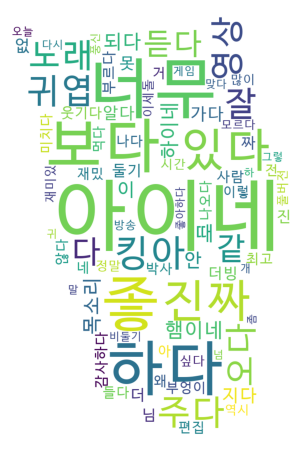

In [8]:
bgimg = Image.open('resource/wakdoo.png')
mask = np.array(bgimg)

wc = WordCloud(font_path="resource/D2Coding.ttf",background_color="white", max_font_size=200, mask=mask)
cloud = wc.generate_from_frequencies(dict(counter.most_common(80)))
cloud.to_file("resource/wordcloud.png")

plt.figure(figsize=(10, 8))
plt.axis('off')
plt.imshow(cloud)
plt.show()

# tokenizer

In [45]:
tokens = ["[PAD]", "[UNK]"] + [t[0] for t in counter.most_common(len(counter))]

with open("resource/tokenizer.pkl", "wb") as f:
    pickle.dump({k: i for i, k in enumerate(tokens)}, f)

In [46]:
tokenizer = Tokenizer("resource/tokenizer.pkl")

In [47]:
sample_text = df.iloc[0, -1]

print(sample_text)
print(tokenizer.encode(sample_text))

아이네 먹다 경양식 돈까스 브랜드 알다 있다
[2, 55, 1271, 1584, 3146, 28, 7]


# word 2 Vec

In [48]:
targets, contexts, labels = [], [], []

sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(tokenizer.vocab_size)

In [49]:
for text in tqdm(df.processed_comment):
    sequence = tokenizer.encode(text)
    if len(sequence) < cfg['num_negative_samples'] * 2 + 1:
        continue
    
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
        sequence,
        vocabulary_size=tokenizer.vocab_size,
        sampling_table=sampling_table,
        window_size=cfg['window_size'],
        negative_samples=0
    )

    for target_word, context_word in positive_skip_grams:
        context_class = tf.expand_dims(tf.constant([context_word], dtype="int64"), 1)
        negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
            true_classes=context_class,
            num_true=1,
            num_sampled=cfg['num_negative_samples'],
            unique=True,
            range_max=tokenizer.vocab_size,
            seed=cfg['random_seed'],
            name="negative_sampling"
        )

        negative_sampling_candidates = tf.expand_dims(negative_sampling_candidates, 1)

        context = tf.concat([context_class, negative_sampling_candidates], 0)
        label = tf.constant([1] + [0] * cfg['num_negative_samples'], dtype="int64")

        targets.append(target_word)
        contexts.append(context)
        labels.append(label)

In [50]:
targets = np.array(targets)
contexts = np.array(contexts)[:,:,0]
labels = np.array(labels)

targets.shape, contexts.shape, labels.shape

((14249,), (14249, 5), (14249, 5))